## LOAD LIBRARIES
Four machine learning models were used to model X-rays of upper extremities of the human body. The upper extremities being modeled were the Hand, Wrist, Forearm, Humerus, Elbow,Shoulder and Finger. The first step in the machine learning model was to load libraries which would be used for the machine learning.

In [1]:
import tensorflow as tf
tf.__version__
import numpy as np 
import collections
from collections import defaultdict
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
from skimage.io import imread
import seaborn as sns
from sklearn.metrics import f1_score,confusion_matrix,classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import warnings

# Remove warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/Users/adejuwon/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading Dataset
Dataset supplied by Stanford was loaded from different folders.
The folders are:

1. TrainSplit: ( Training and validation data)
2. Region:The upper extremity part of the body. These are the seven in number : Hand, Forearm, Wrist, Shoulder, Elbow, Humerus, Finger
3. Patient: The patient information
4. FolderID:patientID
5. Study: Abnormal and abnormal
6. Classes: Images in png format



The link to the original dataset is https://stanfordmlgroup.github.io/competitions/mura/

In [2]:
all_scans_df = pd.DataFrame(dict(path = glob(os.path.join('MURA-v1.1', '*', '*', '*', '*', '*.png'))))
all_scans_df['TrainSplit'] = all_scans_df['path'].map(lambda x: x.split('/')[-5])
all_scans_df['Region'] = all_scans_df['path'].map(lambda x: x.split('/')[2])
all_scans_df['Patient'] = all_scans_df['path'].map(lambda x: x.split('/')[-3])
all_scans_df['FolderId'] = all_scans_df['path'].map(lambda x: x.split('/')[-2])
all_scans_df['Study'] = all_scans_df['FolderId'].map(lambda x: x.split('_')[0])
all_scans_df['classes'] = all_scans_df['FolderId'].map(lambda x: x.split('_')[-1] )


In [3]:
path = glob(os.path.join('MURA-v1.1', '*', '*', '*', '*', '*.png')) #location all png file in harddrive


## Conversion of Dataset to arrays
loaded dataset from the stanford library is converted to array's for easy processing. The folder paths in csv format are the training and the validation inputs and labels.

In [4]:
def load_dataset(csv_path):
    """
    Args:
        train_path: path to csv file containing training dataset
        valid_path: path to csv file containing validation dataset
    Returns:
        x's: np array of inputs
        y's: np array of labels
    """
    inputs = np.loadtxt(csv_path, delimiter=',')[:, 1:]
    labels = np.loadtxt(csv_path, delimiter=',')[:, 0]

    return inputs, labels

bodyparts=['FOREARM','HAND','WRIST','SHOULDER','ELBOW','HUMERUS','FINGER']

for bodypart in bodyparts:    
    if __name__ == '__main__':
        x_train, y_train = load_dataset('train_hist_' + bodypart + '.csv')
        x_valid, y_valid = load_dataset('valid_hist_' + bodypart + '.csv')



## Machine Learning Models  with different hyperparameters :
The machine learning models used for analysing data are the KNN, RandomForest, SVC and Logistic Regression. These models are tuned with various hyperparameters. The best hyperparameter used for tuning the models are inserted in the model to generate a classification report.  

In [5]:
funcs=[(LogisticRegression(random_state=10)),(KNeighborsClassifier()),(RandomForestClassifier(random_state=10)),(SVC(random_state=10))]
params=[{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'logisticregression__solver': ['lbfgs', 'sag', 'saga', 'newton-cg']},
        {'kneighborsclassifier__n_neighbors': np.arange(1,10)},
         {'randomforestclassifier__max_depth': [None, 5, 3, 1],
                  'randomforestclassifier__n_estimators': [10, 25, 50, 75, 100]},
         {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'svc__kernel': ['rbf', 'linear'],
                  'svc__gamma': [0.001, 0.01, 0.1, 1]}]
names=["logreg","knn","randforest","svm"]


## Function to calculate best hyperparameters 

In [6]:
best_params={}

for i in range(0,len(funcs)):
    pipeline=make_pipeline(funcs[i])
    hyperparameters=params[i]
# For loop to select best set of features, hyperparameters
    best_score = 0
    best_param = str()
# Loop
    clf = GridSearchCV(pipeline, hyperparameters, cv=5) # Check hyperparameters
    clf.fit(x_train, y_train)
    if clf.best_score_ > best_score: # If better than others, save
        best_score = clf.best_score_
        best_param = clf.best_params_
        best_params[names[i]]=best_param
        
    print('best parameters: ', best_param)
    print('best score: ', best_score)

best parameters:  {'logisticregression__C': 100, 'logisticregression__solver': 'saga'}
best score:  0.689405684754522
best parameters:  {'kneighborsclassifier__n_neighbors': 9}
best score:  0.7012919896640827
best parameters:  {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 100}
best score:  0.7224806201550388
best parameters:  {'svc__C': 10, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
best score:  0.7152454780361757


In [7]:
best_params = {key:{key2.split('__')[1]:value2 for key2, value2 in value.items()} for key, value in best_params.items()}

## Function to insert hyperparameters into models

In [8]:
def logistic_classifier(x_train, y_train, x_valid):
   
    #log_reg=LogisticRegression(solver="sag",C=100,random_state=10)
    log_reg=LogisticRegression(**best_params["logreg"])
    log_reg.fit(x_train,y_train)
    pred=log_reg.predict(x_valid)
    return pred 

In [9]:
def svm_classifier(x_train, y_train, x_valid):
   
    #clf=svm.SVC(C=100,gamma=1,kernel="rbf")
    clf=svm.SVC(**best_params["svm"])
    clf.fit(x_train,y_train)
    pred_svm=clf.predict(x_valid)
    return pred_svm 



In [10]:
def knn_classifier(x_train, y_train, x_valid):

    #neigh = KNeighborsClassifier(n_neighbors=9)
    neigh=KNeighborsClassifier(**best_params["knn"])
    neigh.fit(x_train,y_train)
    pred_knn=neigh.predict(x_valid)
    return pred_knn 



In [11]:

def RandomForest(x_train, y_train, x_valid):
    #clf = RandomForestClassifier(n_estimators=100,random_state=10,max_depth=None)
    clf= RandomForestClassifier(**best_params["randforest"])
    clf.fit(x_train,y_train)
    pred_clf=clf.predict(x_valid)
    return pred_clf 



In [12]:
bodyparts=['FOREARM','WRIST','HUMERUS','HAND','ELBOW','SHOULDER','FINGER']

## Classification report using tuned hyperparameters

## Random Forest Model classification report

In [13]:
for bodypart in bodyparts:    
        x_train, y_train = load_dataset('train_hist_' + bodypart + '.csv')
        x_valid, y_valid = load_dataset('valid_hist_' + bodypart + '.csv')
        y_pred = RandomForest(x_train, y_train, x_valid)
        print(f'Here are the results for the Random Forest model with the validation set for {bodypart} images.')
        print(classification_report(y_valid, y_pred))


Here are the results for the Random Forest model with the validation set for FOREARM images.
              precision    recall  f1-score   support

         0.0       0.56      0.91      0.69        69
         1.0       0.70      0.22      0.33        64

    accuracy                           0.58       133
   macro avg       0.63      0.57      0.51       133
weighted avg       0.63      0.58      0.52       133

Here are the results for the Random Forest model with the validation set for WRIST images.
              precision    recall  f1-score   support

         0.0       0.67      0.88      0.76       140
         1.0       0.69      0.38      0.49        97

    accuracy                           0.68       237
   macro avg       0.68      0.63      0.63       237
weighted avg       0.68      0.68      0.65       237

Here are the results for the Random Forest model with the validation set for HUMERUS images.
              precision    recall  f1-score   support

         0.0  

## KNN classification report

In [14]:
for bodypart in bodyparts:    
        x_train, y_train = load_dataset('train_hist_' + bodypart + '.csv')
        x_valid, y_valid = load_dataset('valid_hist_' + bodypart + '.csv')
        y_pred = knn_classifier(x_train, y_train, x_valid)
        print(f'Here are the results for the knn_classifier validated {bodypart} images.')
        print(classification_report(y_valid, y_pred))


Here are the results for the knn_classifier validated FOREARM images.
              precision    recall  f1-score   support

         0.0       0.56      0.77      0.65        69
         1.0       0.59      0.36      0.45        64

    accuracy                           0.57       133
   macro avg       0.58      0.56      0.55       133
weighted avg       0.58      0.57      0.55       133

Here are the results for the knn_classifier validated WRIST images.
              precision    recall  f1-score   support

         0.0       0.68      0.77      0.72       140
         1.0       0.59      0.48      0.53        97

    accuracy                           0.65       237
   macro avg       0.64      0.63      0.63       237
weighted avg       0.65      0.65      0.65       237

Here are the results for the knn_classifier validated HUMERUS images.
              precision    recall  f1-score   support

         0.0       0.66      0.60      0.63        68
         1.0       0.63      

## Logistic Regression classification report

In [15]:
for bodypart in bodyparts:    
        x_train, y_train = load_dataset('train_hist_' + bodypart + '.csv')
        x_valid, y_valid = load_dataset('valid_hist_' + bodypart + '.csv')
        y_pred = logistic_classifier(x_train, y_train, x_valid)
        print(f'Here are the results for the logistic_classifier validated {bodypart} images.')
        print(classification_report(y_valid, y_pred))




Here are the results for the logistic_classifier validated FOREARM images.
              precision    recall  f1-score   support

         0.0       0.54      0.94      0.68        69
         1.0       0.67      0.12      0.21        64

    accuracy                           0.55       133
   macro avg       0.60      0.53      0.45       133
weighted avg       0.60      0.55      0.46       133

Here are the results for the logistic_classifier validated WRIST images.
              precision    recall  f1-score   support

         0.0       0.59      0.83      0.69       140
         1.0       0.43      0.19      0.26        97

    accuracy                           0.57       237
   macro avg       0.51      0.51      0.48       237
weighted avg       0.53      0.57      0.52       237

Here are the results for the logistic_classifier validated HUMERUS images.
              precision    recall  f1-score   support

         0.0       0.58      0.54      0.56        68
         1.0  

## SVM classification report

In [16]:
for bodypart in bodyparts:    
    if __name__ == '__main__':
        x_train, y_train = load_dataset('train_hist_' + bodypart + '.csv')
        x_valid, y_valid = load_dataset('valid_hist_' + bodypart + '.csv')
        y_pred = svm_classifier(x_train, y_train, x_valid)
    print(f'Here are the results for the svm_classifier validated {bodypart} images.')
    print(classification_report(y_valid, y_pred))



Here are the results for the svm_classifier validated FOREARM images.
              precision    recall  f1-score   support

         0.0       0.54      0.96      0.69        69
         1.0       0.73      0.12      0.21        64

    accuracy                           0.56       133
   macro avg       0.63      0.54      0.45       133
weighted avg       0.63      0.56      0.46       133

Here are the results for the svm_classifier validated WRIST images.
              precision    recall  f1-score   support

         0.0       0.64      0.84      0.72       140
         1.0       0.57      0.32      0.41        97

    accuracy                           0.62       237
   macro avg       0.61      0.58      0.57       237
weighted avg       0.61      0.62      0.60       237

Here are the results for the svm_classifier validated HUMERUS images.
              precision    recall  f1-score   support

         0.0       0.65      0.66      0.66        68
         1.0       0.65      

## Comparison of Models using Performance Metrics for the Finger Dataset

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
:param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
dfs = []
models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC())]
results = []
names = []
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
target_names = ['positive', 'negative']
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=10)
    cv_results = model_selection.cross_validate(model, x_train, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(x_train, y_train)
    y_pred = clf.predict(x_valid)
    print(name)
    print(classification_report(y_valid, y_pred, target_names=target_names))
    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)



LogReg
              precision    recall  f1-score   support

    positive       0.56      0.91      0.69        92
    negative       0.68      0.20      0.31        83

    accuracy                           0.58       175
   macro avg       0.62      0.56      0.50       175
weighted avg       0.62      0.58      0.51       175

RF
              precision    recall  f1-score   support

    positive       0.59      0.88      0.71        92
    negative       0.71      0.33      0.45        83

    accuracy                           0.62       175
   macro avg       0.65      0.60      0.58       175
weighted avg       0.65      0.62      0.58       175

KNN
              precision    recall  f1-score   support

    positive       0.60      0.82      0.69        92
    negative       0.65      0.39      0.48        83

    accuracy                           0.61       175
   macro avg       0.62      0.60      0.59       175
weighted avg       0.62      0.61      0.59       175

SVM
 

In [18]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

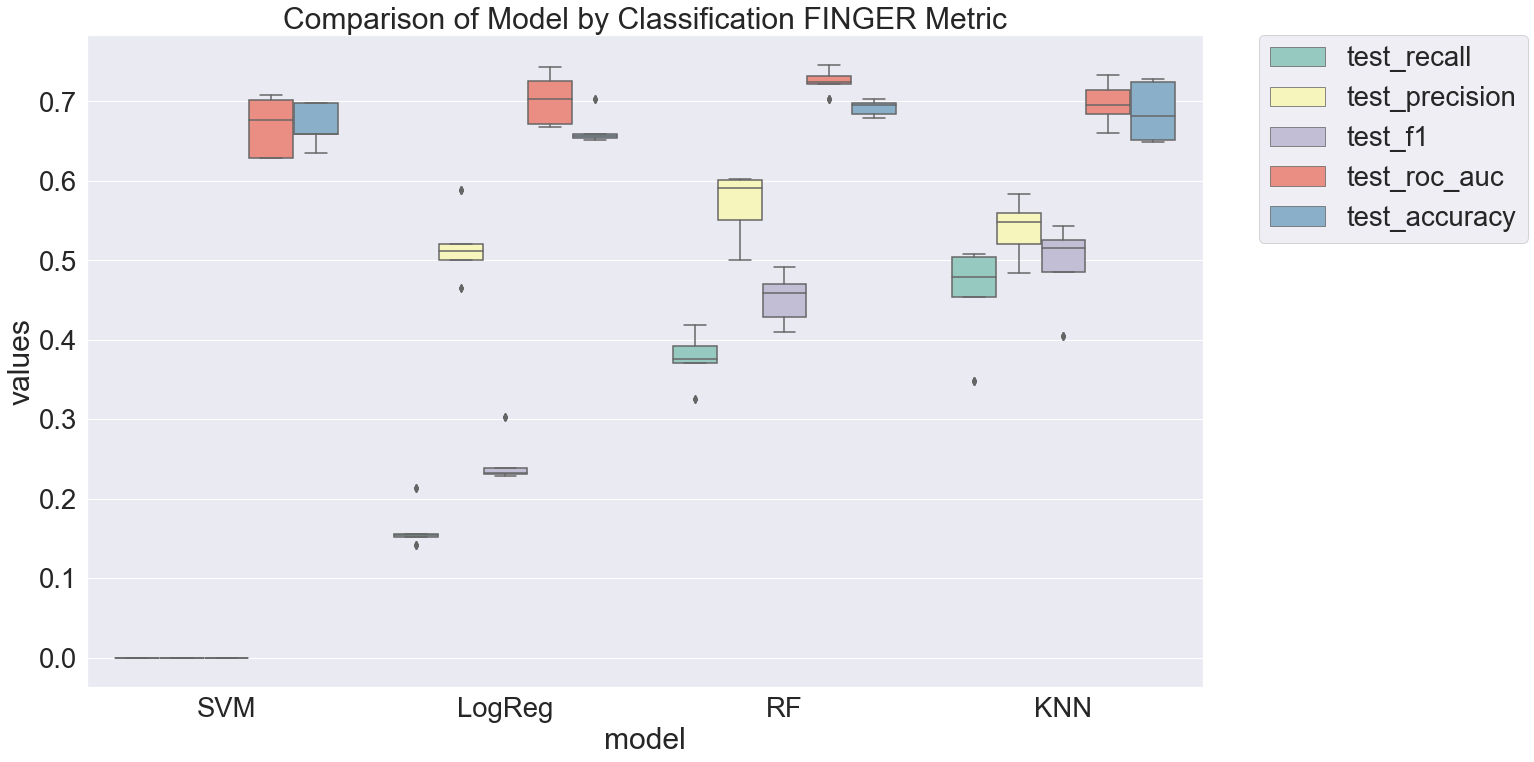

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification FINGER Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

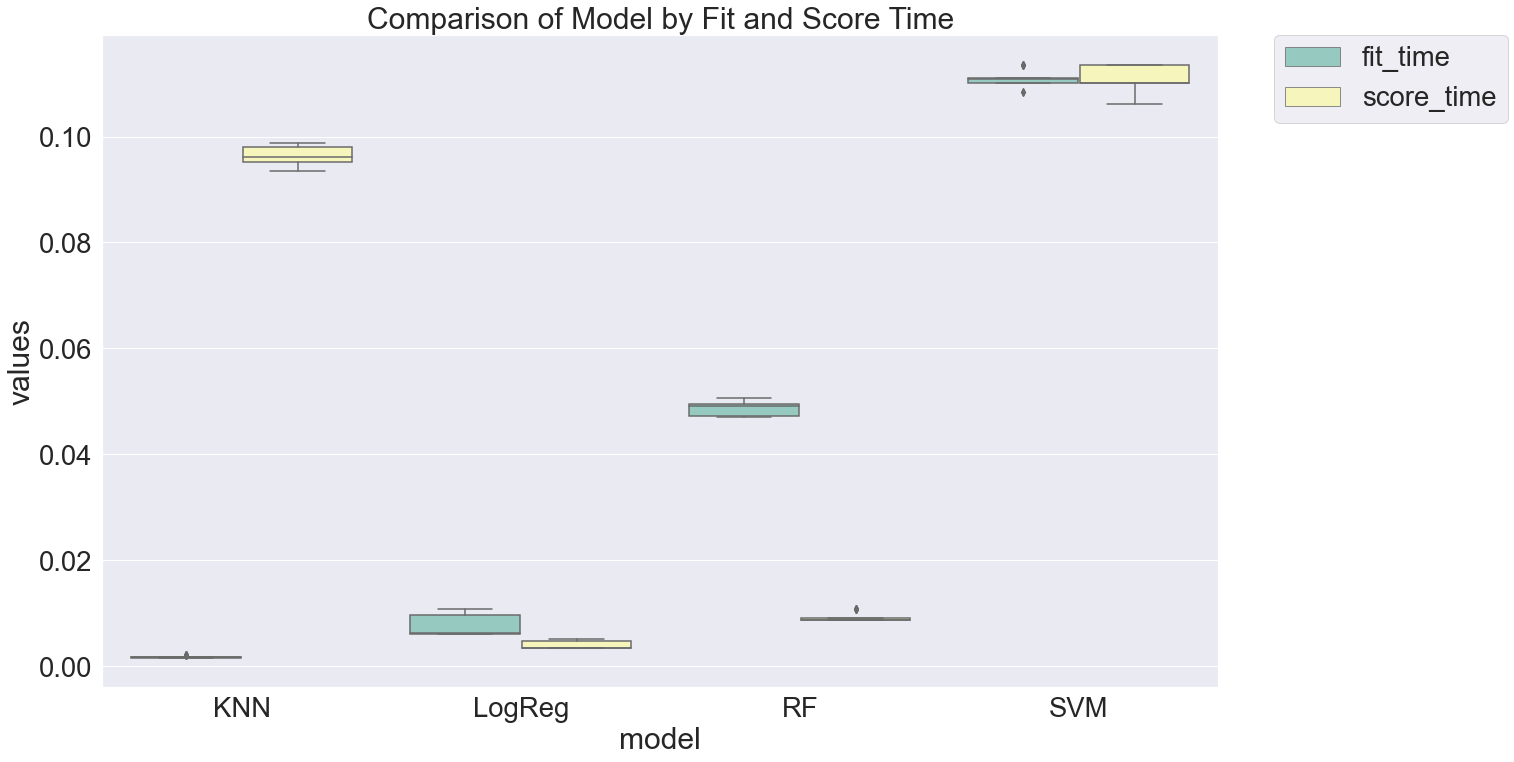

In [20]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

In [21]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_roc_auc           test_recall           test_precision            \
                std      mean         std      mean            std      mean   
model                                                                          
KNN        0.023549  0.694236    0.061221  0.452899       0.033532  0.535401   
LogReg     0.026740  0.698662    0.024342  0.161251       0.037435  0.520883   
RF         0.014009  0.723585    0.028508  0.379893       0.041421  0.568032   
SVM        0.033206  0.671808    0.000000  0.000000       0.000000  0.000000   

       test_accuracy             test_f1            
                 std      mean       std      mean  
model                                               
KNN         0.033399  0.684841  0.050153  0.489853  
LogReg      0.018317  0.663049  0.026646  0.244993  
RF          0.007777  0.692248  0.028361  0.454485  
SVM         0.023099  0.667959  0.000000  0.000000

In [22]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

fit_time           score_time          
             std      mean        std      mean
model                                          
KNN     0.000171  0.001763   0.001928  0.095981
LogReg  0.002101  0.007430   0.000734  0.003976
RF      0.001241  0.048702   0.000854  0.009315
SVM     0.001387  0.110924   0.002571  0.110499